In [139]:
from glob import glob
import pandas as pd
from astropy.io import ascii
import lightkurve as lk
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

# Data (post reduction)

In [140]:
#gp
# ---
gp_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/gp.xls')
gp_data.sort(keys='rel_flux_T1')
gp_badfiles = [str(val) for val in list(gp_data[:2]['Label'])]

gp_cleaned = gp_data[2:] # Remove any frames where AIJ misplaced the aperture and T1 or C2 fluxes are negative/near-0
gp_cleaned.sort(keys='J.D.-2400000')
gp_d, gp_aum_flux, gp_c1_flux = gp_cleaned['J.D.-2400000'], gp_cleaned['rel_flux_T1'], gp_cleaned['rel_flux_C2']
gp_aum_err = gp_cleaned['rel_flux_err_T1']

# ---

#ip
# ---
ip_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/ip.xls')
ip_data.sort(keys='rel_flux_T1')
ip_badfiles = [str(val) for val in list(ip_data[:28]['Label'])]
ip_badfiles.append(ip_data[len(ip_data)-1]["Label"])

ip_cleaned = ip_data[28:len(ip_data)-1] # Same as above but there is a +40 value out of nowhere, don't think that is real
ip_cleaned.sort(keys='J.D.-2400000')
ip_d, ip_aum_flux, ip_c1_flux = ip_cleaned['J.D.-2400000'], ip_cleaned['rel_flux_T1'], ip_cleaned['rel_flux_C2']
ip_aum_err = ip_cleaned['rel_flux_err_T1']

# ---
#rp
# ---
rp_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/rp.xls')
rp_data.sort(keys='rel_flux_T1')
rp_badfiles = [str(val) for val in list(rp_data[:1]['Label'])]

rp_cleaned = rp_data[1:] # Same as above but there is only one bad value
rp_cleaned.sort(keys='J.D.-2400000')
rp_d, rp_aum_flux, rp_c1_flux = rp_cleaned['J.D.-2400000'], rp_cleaned['rel_flux_T1'], rp_cleaned['rel_flux_C2']
rp_aum_err = rp_cleaned['rel_flux_err_T1']

# ---
#U
# ---
U_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/U.xls')
U_data.sort(keys='rel_flux_T1')
U_badfiles = [str(val) for val in list(U_data[(len(U_data))-13:]['Label'])]
U_badfiles.append(U_data[0]["Label"])
U_badfiles.append(U_data[1]["Label"])


U_cleaned = U_data[2:(len(U_data))-13]# Same as above but there are 13 values with substantially too large flux values, and 2 with values too low 
U_cleaned.sort(keys='J.D.-2400000')
U_d, U_aum_flux, U_c1_flux = U_cleaned['J.D.-2400000'], U_cleaned['rel_flux_T1'], U_cleaned['rel_flux_C2']
U_aum_err = U_cleaned['rel_flux_err_T1']

# ---
#B
# ---
B_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/B.xls')

B_cleaned = B_data.copy()
B_cleaned.sort(keys='J.D.-2400000')
B_d, B_aum_flux, B_c1_flux = B_cleaned['J.D.-2400000'], B_cleaned['rel_flux_T1'], B_cleaned['rel_flux_C2']
B_aum_err = B_cleaned['rel_flux_err_T1']

# ---
#V
# ---
V_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/V.xls')

V_cleaned = V_data.copy()
V_cleaned.sort(keys='J.D.-2400000')
V_d, V_aum_flux, V_c1_flux = V_cleaned['J.D.-2400000'], V_cleaned['rel_flux_T1'], V_cleaned['rel_flux_C2']
V_aum_err = V_cleaned['rel_flux_err_T1']
# ---

In [141]:
gp_ds = [int(d) for d in gp_d]
ip_ds = [int(d) for d in ip_d]
rp_ds = [int(d) for d in rp_d]
U_ds = [int(d) for d in U_d]
B_ds = [int(d) for d in B_d]
V_ds = [int(d) for d in V_d]

In [158]:
def binned_lc(datelist, fluxes, errors):
    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})
    date_counter, flux_counter, num_counter, error_counter  = 0, 0, 0, 0
    for num, dates in enumerate(datelist):
        if num==0:
            flux_counter+=fluxes[num]
            date_counter+=dates
            error_counter+=errors[num]     
            num_counter+=1
        else:
            datediffs = np.diff(datelist) 
            if datediffs[num-1] > 0.45:
                if ((flux_counter!=0) & (num_counter!=0)):
                    returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, date_counter/num_counter, error_counter/num_counter]
                date_counter, flux_counter, num_counter, error_counter  = 0, 0, 0, 0
            else:
                flux_counter+=fluxes[num]
                date_counter+=dates
                error_counter+=errors[num]     
                num_counter+=1
    fluxes = [val for val in returned_binnedlc['flux'].values]
    errors = [val for val in returned_binnedlc['errs'].values]
    times = [val for val in returned_binnedlc['times'].values]
    final = lk.LightCurve(time=times, flux=fluxes, flux_err=errors)
    folded_fin = final.fold(4.86, epoch_time=2400000, epoch_phase=1)
    return final, folded_fin

In [147]:
'''
def binned_lc(dates, fluxes, errors):
    current_date = 0
    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})
    flux_counter = 0
    num_counter = 0
    error_counter = 0
    for num, date in enumerate(dates):
        if current_date != date:
            if ((flux_counter!=0) & (num_counter!=0)):
                returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, current_date, error_counter/num_counter]
            flux_counter = 0
            num_counter = 0
            error_counter = 0
            current_date = date
        else:
            flux_counter+=fluxes[num]
            error_counter+=errors[num]     
            num_counter+=1 
    fluxes = [val for val in returned_binnedlc['flux'].values]
    errors = [val for val in returned_binnedlc['errs'].values]
    times = [int(val) for val in returned_binnedlc['times'].values]
    final = lk.LightCurve(time=times, flux=fluxes, flux_err=errors)
    folded_fin = final.fold(4.86, epoch_time=2400000, epoch_phase=1)
    return final, folded_fin

'''

'\ndef binned_lc(dates, fluxes, errors):\n    current_date = 0\n    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})\n    flux_counter = 0\n    num_counter = 0\n    error_counter = 0\n    for num, date in enumerate(dates):\n        if current_date != date:\n            if ((flux_counter!=0) & (num_counter!=0)):\n                returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, current_date, error_counter/num_counter]\n            flux_counter = 0\n            num_counter = 0\n            error_counter = 0\n            current_date = date\n        else:\n            flux_counter+=fluxes[num]\n            error_counter+=errors[num]     \n            num_counter+=1 \n    fluxes = [val for val in returned_binnedlc[\'flux\'].values]\n    errors = [val for val in returned_binnedlc[\'errs\'].values]\n    times = [int(val) for val in returned_binnedlc[\'times\'].values]\n    final = lk.LightCurve(time=times, flux=fluxes, flux_err=errors)\n    f

In [148]:
gp_binned, gp_folded = binned_lc(gp_d, gp_aum_flux, gp_aum_err)
rp_binned, rp_folded = binned_lc(rp_d, rp_aum_flux, rp_aum_err)
ip_binned, ip_folded = binned_lc(ip_d, ip_aum_flux, ip_aum_err)
U_binned, U_folded = binned_lc(U_d, U_aum_flux, U_aum_err)
B_binned, B_folded = binned_lc(B_d, B_aum_flux, B_aum_err)
V_binned, V_folded = binned_lc(V_d, V_aum_flux, V_aum_err)

In [149]:
gp_binned.to_csv('binned_lcs/gp.csv', overwrite=True) 
ip_binned.to_csv('binned_lcs/ip.csv', overwrite=True) 
rp_binned.to_csv('binned_lcs/rp.csv', overwrite=True) 
U_binned.to_csv('binned_lcs/U.csv', overwrite=True) 
B_binned.to_csv('binned_lcs/B.csv', overwrite=True) 
V_binned.to_csv('binned_lcs/V.csv', overwrite=True) 

In [150]:
gp_folded.to_csv('folded_lcs/gp.csv', overwrite=True) 
ip_folded.to_csv('folded_lcs/ip.csv', overwrite=True) 
rp_folded.to_csv('folded_lcs/rp.csv', overwrite=True) 
U_folded.to_csv('folded_lcs/U.csv', overwrite=True) 
B_folded.to_csv('folded_lcs/B.csv', overwrite=True) 
V_folded.to_csv('folded_lcs/V.csv', overwrite=True) 

In [151]:
gp_folded /= np.median(gp_folded[(gp_folded['time'] > 0.5) &  (gp_folded['time'] < 1.0)]['flux'])
ip_folded /= np.median(ip_folded[(ip_folded['time'] > 0.5) &  (ip_folded['time'] < 1.0)]['flux'])
rp_folded /= np.median(rp_folded[(rp_folded['time'] > 0.5) &  (rp_folded['time'] < 1.0)]['flux'])
U_folded /= np.median(U_folded[(U_folded['time'] > 0.5) &  (U_folded['time'] < 1.0)]['flux'])
B_folded /= np.median(B_folded[(B_folded['time'] > 0.5) &  (B_folded['time'] < 1.0)]['flux'])
V_folded /= np.median(V_folded[(V_folded['time'] > 0.5) &  (V_folded['time'] < 1.0)]['flux'])

In [152]:
len(V_folded)

24

# Phase folded and binned without errors

In [153]:

%matplotlib inline
'''
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 10))

gp_folded.scatter(ax=ax, label='gp', c='#0B6E4F', s=50)
rp_folded.scatter(ax=ax, label='ip', c='#F9DB6D', s=50)
ip_folded.scatter(ax=ax, label='rp', c='#764248', s=50)
U_folded.scatter(ax=ax, label='U', c="#004BA8", s=50)
B_folded.scatter(ax=ax, label='B' , c="#6CCFF6", s=50)
V_folded.scatter(ax=ax, label='V' , c="#FFFFFF", s=50)

ax.legend()
'''

'\nplt.style.use(\'dark_background\')\nfig, ax = plt.subplots(figsize=(16, 10))\n\ngp_folded.scatter(ax=ax, label=\'gp\', c=\'#0B6E4F\', s=50)\nrp_folded.scatter(ax=ax, label=\'ip\', c=\'#F9DB6D\', s=50)\nip_folded.scatter(ax=ax, label=\'rp\', c=\'#764248\', s=50)\nU_folded.scatter(ax=ax, label=\'U\', c="#004BA8", s=50)\nB_folded.scatter(ax=ax, label=\'B\' , c="#6CCFF6", s=50)\nV_folded.scatter(ax=ax, label=\'V\' , c="#FFFFFF", s=50)\n\nax.legend()\n'

# Phase folded and binned w/ errors

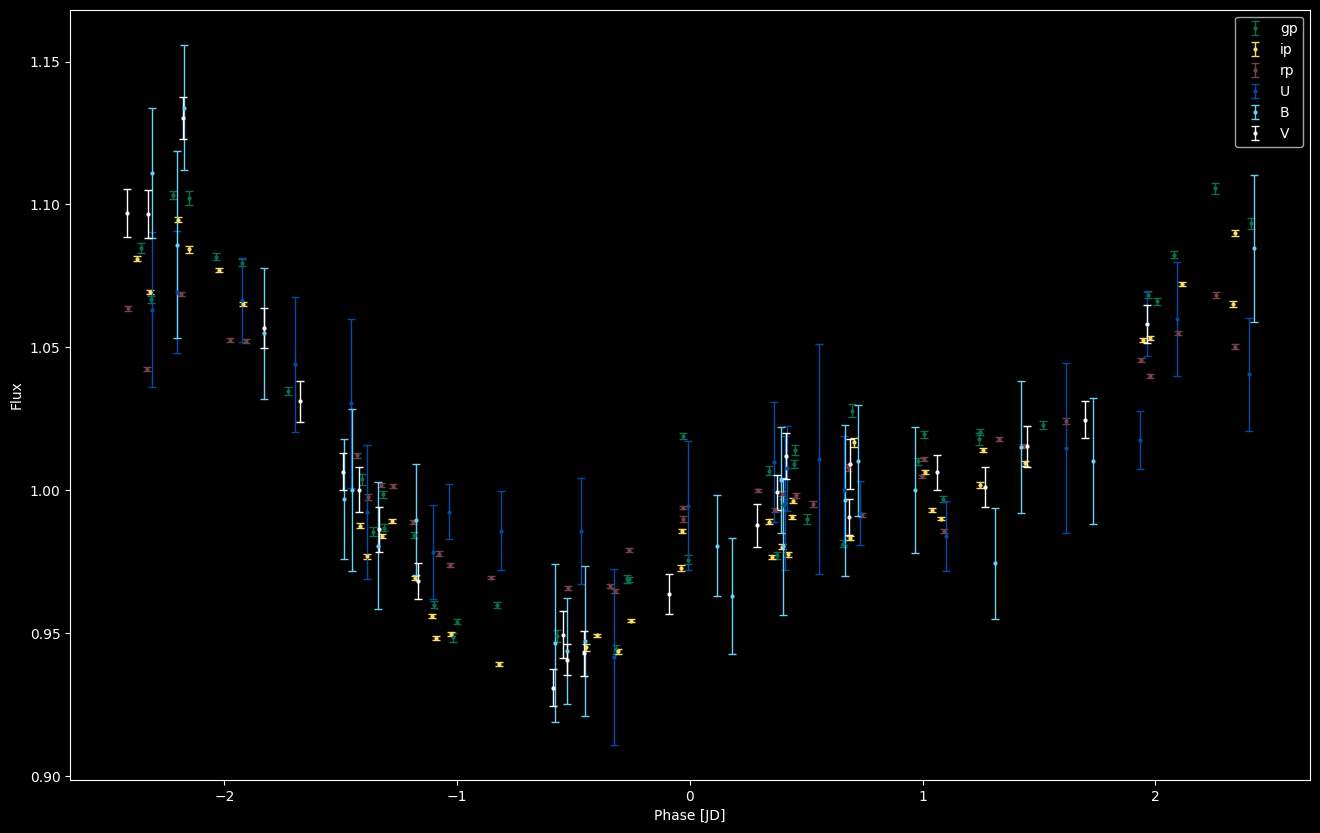

In [156]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('dark_background')

gp_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='gp', c='#0B6E4F')
rp_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='ip', c='#F9DB6D')
ip_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='rp', c='#764248')

U_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='U', c="#004BA8")
B_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='B' , c="#6CCFF6")
V_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='V' , c="#FFFFFF")


ax.legend()

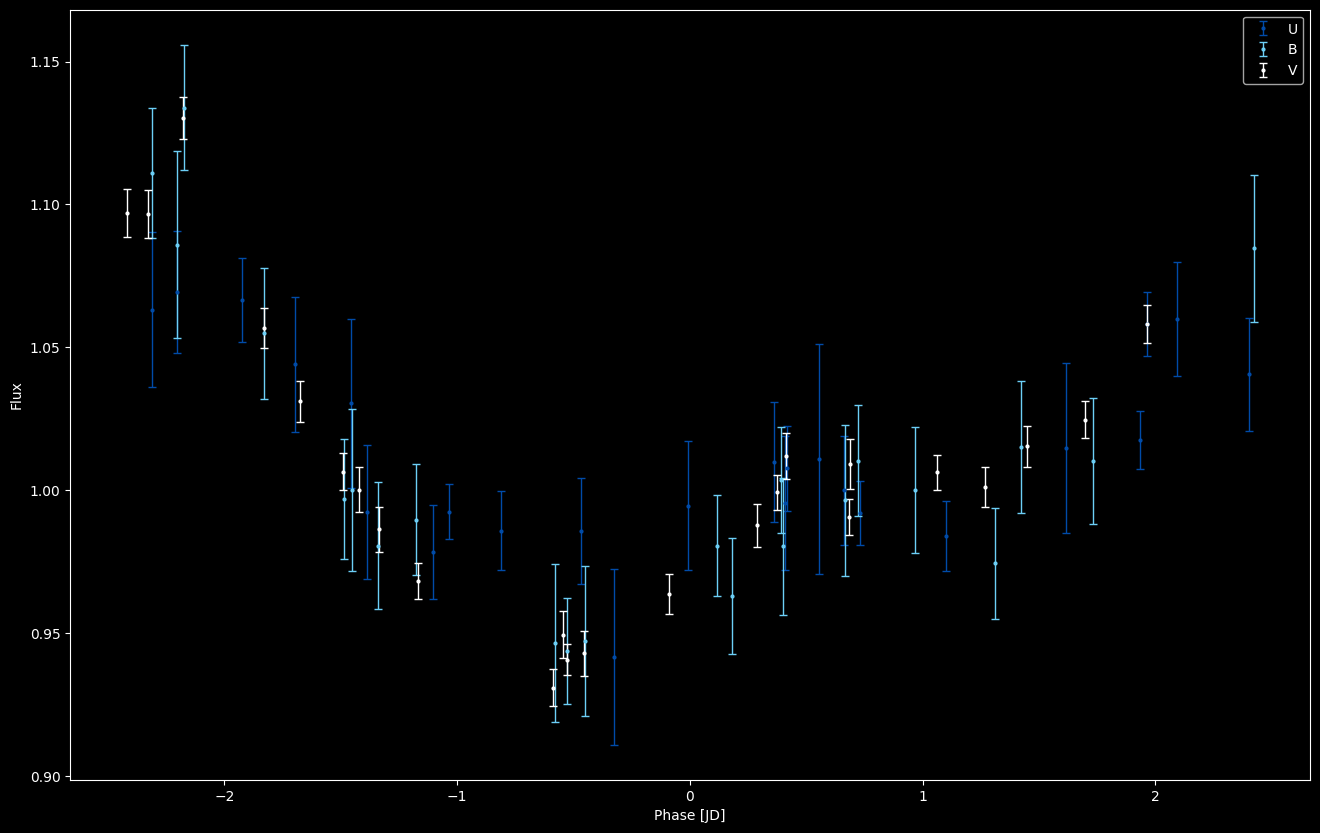

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('dark_background')
ax.legend()